In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
def compute_kernel(X, Y, kernel_fn):
    vectorized_binary_fn = np.vectorize(kernel_fn, signature='(),()->()')
    x_indices, y_indices = np.meshgrid(np.arange(X.shape[0]), np.arange(Y.shape[0]))
    return vectorized_binary_fn(X[x_indices], Y[y_indices])

def sum(kernels):
    def kernel(x1, x2):
        s = 0
        for k in kernels:
            s += k(x1, x2)
        return s
    return kernel

def gaussian(b):
    def kernel(x1, x2):
        return np.exp((-0.5)*(x1-x2)**2/b**2)
    return kernel

def polynomial(n):
    def kernel(x1, x2):
        return (1 + 0.01*x1*x2)**n
    return kernel

def periodic(p):
    def kernel(x1, x2):
        return np.cos((x1-x2)/p)**2
    return kernel

def linear(a):
    def kernel(x1, x2):
        return a*(x1-x2)
    return kernel


In [3]:
x = np.arange(100)
# print(x)

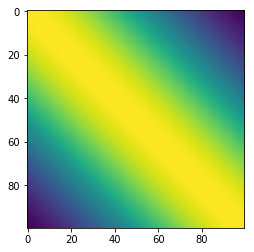

In [4]:
f_mean = np.zeros([100])
def kernel(x1, x2):
    return gaussian(50)(x1, x2)
K = compute_kernel(x, x, kernel) #+ np.identity(100)*0.1**2
plt.imshow(K)

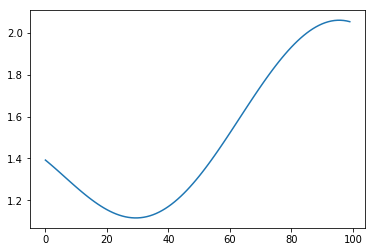

In [5]:
f1 = np.random.multivariate_normal(f_mean, K)
plt.plot(f1)

(100, 8) (8, 8)
k_x_x.shape (100, 100)
k_x_D.shape (100, 8)
kk.shape (100, 100)
cov.shape (100, 100)
[ 1.00018483  0.99668407  0.98270263  0.9388855   0.83215529  0.63348757
  0.36045938  0.10705399  0.001999    0.10704719  0.36035731  0.632714
  0.82790428  0.9206692   0.92066913  0.82790405  0.63271349  0.36035654
  0.10704655  0.001999    0.10704655  0.36035653  0.6327134   0.82790352
  0.9206669   0.92066166  0.82788424  0.63267313  0.36029834  0.10700324
  0.001999    0.1067278   0.3572308   0.61696102  0.77227849  0.77226615
  0.61692286  0.35717309  0.10668456  0.001999    0.10668453  0.3571727
  0.61692086  0.77225896  0.77225896  0.61692085  0.3571727   0.10668452
  0.001999    0.10668452  0.3571727   0.61692085  0.77225896  0.77225896
  0.61692085  0.3571727   0.10668452  0.001999    0.10668452  0.3571727
  0.61692085  0.77225896  0.77225896  0.61692086  0.3571727   0.10668453
  0.001999    0.10668456  0.35717309  0.61692288  0.77226623  0.77227873
  0.61696153  0.35723157  0

(0, 100)

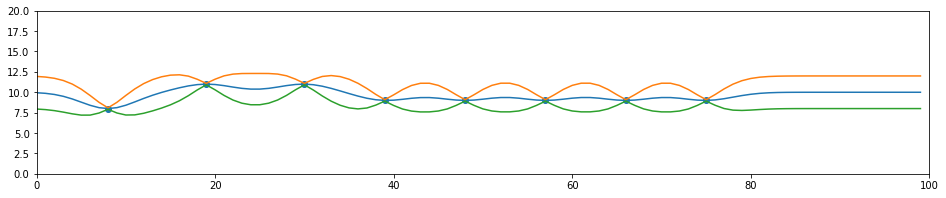

In [7]:
class GaussianProcess(object):
    def compute_kernel(X, Y, kernel_fn):
        x_indices, y_indices = np.meshgrid(np.arange(X.shape[0]), np.arange(Y.shape[0]))
        return kernel_fn(X[x_indices], Y[y_indices])

    def __init__(self, x, y, kernel_fn, mean_fn, sigma=0):
        self.x = x
        self.y = y
        self.kernel_fn = np.vectorize(kernel_fn, signature='(),()->()')
        self.mean_fn = mean_fn
        self.sigma = sigma
        self.K = compute_kernel(self.x, self.x, self.kernel_fn)
        self.inv_K = inv(self.sigma*np.identity(self.x.shape[0]) + self.K)
        
    def mean(self, x):
        k_x_D = compute_kernel(self.x, x, self.kernel_fn)
        print(k_x_D.shape, self.inv_K.shape)
        return self.mean_fn(x) + np.dot(np.dot(k_x_D, self.inv_K), (self.y - self.mean_fn(self.x)))

    def covariance(self, x):
        k_x_x = compute_kernel(x, x, self.kernel_fn)
        k_x_D = compute_kernel(self.x, x, self.kernel_fn)
        print('k_x_x.shape',k_x_x.shape)
        print('k_x_D.shape',k_x_D.shape)
        kk = np.dot(np.dot(k_x_D, self.inv_K), k_x_D.T)
        print('kk.shape', kk.shape)
        cov = k_x_x - kk + self.sigma*np.identity(x.shape[0])
        print('cov.shape', cov.shape)
        return cov
        
        
inst_p = np.round(10+1*np.random.normal(size=8)).astype(np.int)
t = np.cumsum(inst_p)
gp = GaussianProcess(t, inst_p, sigma=0.001, kernel_fn=gaussian(3), mean_fn=lambda x: 10+np.zeros_like(x))
mm = gp.mean(x)
cov = gp.covariance(x)

plt.figure(figsize=(16,3))
plt.scatter(t, inst_p)
plt.plot(x, mm)
# plt.plot(x, cov*10)
stds = np.sqrt(cov.diagonal())
print(cov.diagonal())
plt.plot(x, mm + 2*stds)
plt.plot(x, mm - 2*stds)
# plt.plot(x, np.random.multivariate_normal(mm, cov))
# plt.patch(x, mm + 2*stds, alpha=0.2, line_width=0, color='grey', legend='Uncertainty')

plt.ylim(0,20)
plt.xlim(0,100)